In [1]:
from loica import *
from flapjack import *

import matplotlib.pyplot as plt
import numpy as np
import getpass
import datetime
import random as rd
import pandas as pd

from numpy.fft import fft, ifft, fftfreq
from scipy.interpolate import interp1d, UnivariateSpline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_absolute_error

from scipy.signal import savgol_filter, medfilt

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 6})

In [2]:
import seaborn as sns

In [3]:
def step_profile(t0, tmax, nt, a, b, tau):
    t = np.linspace(t0, tmax, nt)
    profile = np.zeros((nt,))
    profile[t<tau] = a
    profile[t>=tau] = b
    return interp1d(t, profile)

def brownian_gr_profile(t0, tmax, nt, sigma, corr):
    B0 = 0.01
    mu_max = 1
    Bmax = 1
    l = 1
    t = np.linspace(t0, tmax, nt)
    dt = (tmax-t0)/nt
    gr = gompertz_growth_rate(t, B0, Bmax, mu_max, l)
    gr = interp1d(t, gr, bounds_error=False, fill_value='extrapolate')
    
    steps = np.exp(corr * np.log(gr(t+dt)/gr(t)) + np.sqrt(1-corr**2) * np.random.normal(size=(nt,), scale=sigma))
    profile = np.cumprod(steps)
    profile = savgol_filter(profile, 21, 2)
    profile = profile / profile.max()
    return interp1d(t, profile)

def brownian_profile(t0, tmax, nt, sigma):
    steps = np.random.lognormal(size=(nt,), sigma=sigma)
    profile = np.cumprod(steps)
    profile = savgol_filter(profile, 21, 2)
    profile = profile / profile.max()
    t = np.linspace(t0, tmax, nt)
    return interp1d(t, profile)

def random_profile(t0, tmax, nt, fmax):
    freqs = fftfreq(nt)
    tff = np.zeros((nt,), dtype=np.complex)
    ncomps = len(freqs[np.abs(freqs)<fmax])
    tff[np.abs(freqs)<fmax] = np.random.normal(size=(ncomps,)) + np.random.normal(size=(ncomps,))*1j
    profile = ifft(tff).real
    profile = (profile - profile.min()) / (profile.max() - profile.min())
    profile = profile + np.random.uniform(-profile.min(), 1)
    profile = profile / profile.max()
    #profile = (profile - profile.min()) / (profile.max() - profile.min())
    t = np.linspace(t0, tmax, nt)
    return interp1d(t, profile)

def spline_profile(t0, tmax, nst):
    st = np.linspace(t0, tmax, nst)
    y = np.random.uniform(size=st.shape)
    profile = UnivariateSpline(st, y-y.min(), s=0)
    return profile

def gaussian_profile(t0, tmax, nt, n_blobs):
    t = np.linspace(t0, tmax, nt)
    profile = np.zeros_like(t)
    means = np.linspace(t.min(), t.max(), n_blobs)
    vars = [t.max()/n_blobs]*n_blobs #res.x[:n_blobs]
    heights = np.random.lognormal(size=(n_blobs,))
    for mean,var,height in zip(means, vars, heights):
        gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
        profile += gaussian
    return interp1d(t, profile/profile.max())

def growth_rate_profile(t):
    B0 = 0.01
    mu_max = np.random.uniform(0.5, 1)
    Bmax = 1
    l = np.random(0, 4)
    return gompertz_growth_rate(t, B0, Bmax, mu_max, l)

def growth_rate(t):
    B0 = 0.01
    mu_max = 1
    Bmax = 1
    l = 1
    return gompertz_growth_rate(t, B0, Bmax, mu_max, l)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 0.5)

def random_gompertz_growth():
    B0 = 0.01
    mu_max = np.random.uniform(0.5, 1)
    Bmax = 1
    l = np.random.uniform(0, 4)
    def biomass(t):
        b = gompertz(t, B0, Bmax, mu_max, l)
        return b
    def growth_rate(t):
        gr = gompertz_growth_rate(t, B0, Bmax, mu_max, l)
        return gr
    return biomass,growth_rate

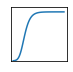

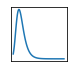

In [4]:
plt.figure(figsize=(1,1), frameon=False)
t = np.linspace(0, 24, 100)
plt.plot(biomass(t), '-')
plt.ylim([0,1.1])
plt.xticks([])
plt.yticks([])
plt.savefig('growth_thumb.png', dpi=300)

plt.figure(figsize=(1,1), frameon=False)
plt.plot(growth_rate(t), '-')
#plt.ylim([0,1.1])
plt.xticks([])
plt.yticks([])
plt.savefig('growth_rate_thumb.png', dpi=300)

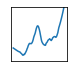

In [5]:
plt.figure(figsize=(1,1), frameon=False)
t = np.linspace(0, 24, 100)
for i in range(1):
    plt.plot(t, brownian_profile(0, 24, 100, 0.25)(t), '-')
plt.ylim([0,1])
plt.xticks([])
plt.yticks([])
plt.savefig('profile_thumb.png', dpi=300)

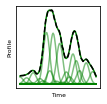

In [6]:
from scipy.optimize import least_squares
t0,tmax = 0,24
nt = 100
n_blobs = 24
t = np.linspace(t0, tmax, nt)
means = np.linspace(t.min(), t.max(), n_blobs, endpoint=True)
var = t.max()/n_blobs

def residuals(profile):
    def func(x):
        heights = x
        gprofile = np.zeros_like(t)
        for mean,height in zip(means, heights):
            gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
            gprofile += gaussian
        return gprofile - profile
    return func

plt.figure(figsize=(1.5,1.5))
bprof = brownian_profile(0, 24, 100, 0.25)(t)
lower_bounds = [0]*24
upper_bounds = [50]*24
bounds = [lower_bounds, upper_bounds]
res = least_squares(residuals(bprof), x0=[1]*24, bounds=bounds)
bheights = res.x


rbprof = np.zeros_like(t)
for mean,height in zip(means, bheights):
    gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
    rbprof += gaussian
    plt.plot(t, gaussian, 'g-', alpha=0.5)
plt.plot(t, rbprof, 'g')
plt.plot(t, bprof, 'k--')
plt.xlabel('Time')
plt.ylabel('Profile')
plt.xticks([])
plt.yticks([])
plt.savefig('gaussian_basis.png', dpi=300)

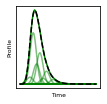

In [7]:
plt.figure(figsize=(1.5,1.5))
gprof = gompertz_growth_rate(t, 0.01, 1, 1, 3)
lower_bounds = [0]*24
upper_bounds = [50]*24
bounds = [lower_bounds, upper_bounds]
res = least_squares(residuals(gprof), x0=[1]*24, bounds=bounds)
bheights = res.x


rgprof = np.zeros_like(t)
for mean,height in zip(means, bheights):
    gaussian = height * np.exp(-(t-mean)*(t-mean) / var / 2) / np.sqrt(2 * np.pi * var)
    rgprof += gaussian
    plt.plot(t, gaussian, 'g-', alpha=0.5)
plt.plot(t, rgprof, 'g')
plt.plot(t, gprof, 'k--')
plt.xlabel('Time')
plt.ylabel('Profile')
plt.xticks([])
plt.yticks([])
plt.savefig('gr_gaussian_basis.png', dpi=300)

In [9]:
#fj = Flapjack(url_base='flapjack.rudge-lab.org:8000')
fj = Flapjack(url_base='localhost:8000')
fj.log_in(username=input('Flapjack username: '), password=getpass.getpass('Password: '))

No user logged in.
Flapjack username: tim
Password: ········


In [10]:
#Defined data structure
columns = { 
    'Profile':[], 
    'nsr':[], 
    'eps':[],
    'Iteration':[], 
    'Method':[], 
    'Metric':[], 
    'Score':[], 
    'Data_true_profile':[],
    'Data_method_profile':[] 
}
df_characterization = pd.DataFrame(columns)

In [11]:
profiles = ['step'] #'brownian', 'growth_rate', 'random', 'gaussian']
methods = ['direct', 'loica']
nsr = [0, 1e-4, 1e-3]
metrics = ['MAE', 'MSE']
#metrics = ['explained variance', 'MAE', 'MSE', 'mean_poisson', 'mean_gamma']

In [12]:
study = fj.get('study', name='Method comparison testing')
#fj.delete('study', study.id[0])
if len(study)==0:
    study = fj.create('study', name='Method comparison testing', description='Testing methods of profile reconstruction')

In [13]:
study

,id,is_owner,shared_with,name,description,doi,public
0,3,True,[],Method comparison testing,Testing methods of profile reconstruction,,False


In [14]:
#DNA and Vector are created inside the loop

sfp1 = fj.get('signal', name='SFP0')
if len(sfp1)==0:
    sfp1 = fj.create('signal', name='SFP0', description='Simulated FP', color='green')
sfp1 = Reporter(name='CFP', degradation_rate=0, init_concentration=0, signal_id=sfp1.id[0])

od = fj.get('signal', name='OD')
if len(od)==0:
    od = fj.create('signal', name='OD', description='Optical density', color='black')

media = fj.get('media', name='Loica')
if len(media)==0:
    media = fj.create('media', name='Loica', description='Simulated loica media')
    
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')
    
biomass_signal = fj.get('signal', name='OD')

study = fj.get('study', name='Method comparison')
if len(study)==0:
    study = fj.create('study', name='Method comparison', description='Testing')

In [21]:
samples = []
profile_timeseries = []
growth_rate_timeseries = []
t = np.linspace(0, 24, 100)
for n in nsr:
    for p in profiles:
        print(f'Profile: {p}, NSR: {n}')

        #iterar por 100 dnas y anadirlos a samples
        for i in range(100):
            #definir nobres para dnas
            name = 'Const_%s_nsr_%f_it_%i' % (p,n,i)
            dna = fj.get('dna', name=name)
            if len(dna)==0:
                dna = fj.create('dna', name=name)
            vector = fj.get('vector',name=name)    
            if len(vector)==0:
                vector = fj.create('vector', name=name, dnas=dna.id)

            #create the profile
            if p == 'random':
                profile = random_profile(t0=0, tmax=24, nt=100, fmax=0.05)
            elif p == 'spline':
                profile = spline_profile(t0=0, tmax=24, nst=20)
            elif p == 'gaussian':
                profile = gaussian_profile(t0=0, tmax=24, nt=100, n_blobs=20) # de que depende n_blobs?
            elif p=='growth_rate':
                profile = growth_rate
            elif p=='brownian':
                profile = brownian_profile(t0=0, tmax=24, nt=100, sigma=0.25)
            elif p=='step':
                profile = step_profile(t0=0, tmax=24, nt=100, a=0, b=1, tau=12)
            profile_timeseries.append(profile)
            
            #creation of LOICA model
            #GeneticNetwork
            const = GeneticNetwork(vector=vector.id[0])
            const.add_reporter(sfp1)
            const.add_operator(Source(output=sfp1, rate=1, profile=profile))
            #Assay
            biomass, growth_rate = random_gompertz_growth()
            growth_rate_timeseries.append(growth_rate)
            metab = SimulatedMetabolism(biomass, growth_rate)
            for _ in range(1):
                sample = Sample(circuit=const, 
                                metabolism=metab,
                                media=media.id[0],
                                strain=strain.id[0])
                samples.append(sample)
               
    print(f'Creating assay for NSR {n}')
    assay = Assay(samples, 
          n_measurements=100, 
          interval=0.24,
          name=f'Loica constitutive expression NSR = {n}',
          description='Simulated constitutive gene generated by loica',
          biomass_signal_id=biomass_signal.id[0]
         )
    #Run and upload Assay
    print(f'Running simulation for NSR {n}')    
    assay.run(nsr=n, biomass_bg=0.1, fluo_bg=0.1)
    print(f'Uploading data for NSR {n}')
    assay.upload(fj, study.id[0])


Profile: step, NSR: 0
Creating assay for NSR 0
Running simulation for NSR 0
Uploading data for NSR 0
Profile: step, NSR: 0.0001
Creating assay for NSR 0.0001
Running simulation for NSR 0.0001
Uploading data for NSR 0.0001
Profile: step, NSR: 0.001
Creating assay for NSR 0.001
Running simulation for NSR 0.001
Uploading data for NSR 0.001


In [15]:
study

,id,is_owner,shared_with,name,description,doi,public
0,201,True,[],Method comparison,Testing,,True


In [ ]:
df_characterization = pd.DataFrame()
cfp = fj.get('signal', name='SFP0')
t = np.linspace(0, 24, 100)
pi = 0
eps = 0.01
n = 1e-3
for n in nsr:
    for p in profiles:
        for i in range(100):
            print('Characterizing ', p, n, i)
            profile = profile_timeseries[pi]
            growth_rate = growth_rate_timeseries[pi]
            pi += 1

            #get dnas
            name = 'Const_%s_nsr_%f_it_%i' % (p,n,i)
            vector = fj.get('vector',name=name)    
            #Characterize using indirect method
            er_indirect = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (indirect)',
                    biomass_signal=biomass_signal.id,
                    pre_smoothing=11,
                    post_smoothing=11,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )
            #Characterize using direct method
            er_direct = fj.analysis(media=media.id, 
                    strain=strain.id,
                    vector=[vector.id[0]],
                    type='Expression Rate (direct)',
                    biomass_signal=biomass_signal.id,
                    eps_L=1e-5,
                    #bg_correction=2,
                    #min_biomass=0.05,
                    #remove_data=False
                      )
            true_profile = profile(t)
            indirect = er_indirect[er_indirect.Signal=='SFP0'].groupby('Time').Rate.mean().values
            direct = er_direct[er_direct.Signal=='SFP0'].groupby('Time').Rate.mean().values
            mse_indirect = mean_squared_error(true_profile[1:], indirect)
            mse_direct = mean_squared_error(true_profile[1:], direct)
            temp1 = {'Profile':p, 'nsr':n, 'eps':0, 'Iteration':i, 'Method':'Indirect', 'Metric':'MSE', 'Score':mse_indirect,'Data_true_profile':true_profile, 'Data_method_profile':indirect }  
            temp2 = {'Profile':p, 'nsr':n, 'eps':0, 'Iteration':i, 'Method':'Direct', 'Metric':'MSE', 'Score':mse_direct, 'Data_true_profile':true_profile, 'Data_method_profile':direct}  
            df_characterization = df_characterization.append([temp1, temp2], ignore_index=True)
            for eps in [1e-2]: #[0, 1e-3, 1e-2, 1e-1]:
                #Characterize using LOICA
                source = Source(None, 0) #const.operators[0]
                source.characterize(
                    fj,
                    vector=vector.id,
                    media=media.id,
                    strain=strain.id,
                    signal=cfp.id,
                    biomass_signal=biomass_signal.id,
                    n_gaussians=24,
                    epsilon=eps
                )
                #print(f'$\gamma = {source.gamma}')
                #Profiles
                LOICA_profile = source.profile(t) * source.rate
                #Metrics
                #MSE
                mse_gaussian = mean_squared_error(true_profile[1:], LOICA_profile[1:])
                temp3 = {'Profile':p, 'nsr':n, 'eps':eps, 'Iteration':i, 'Method':'Gaussian', 'Metric':'MSE', 'Score':mse_gaussian, 'Data_true_profile':true_profile, 'Data_method_profile':LOICA_profile}
                df_characterization = df_characterization.append([temp3], ignore_index=True)

                

In [ ]:
df_growth_rate = pd.DataFrame()
cfp = fj.get('signal', name='SFP0')
t = np.linspace(0, 23, 100)
pi = 0
eps = 0.01
for n in nsr:
    for p in profiles:
        for i in range(100):
            print('Characterizing ', p, n, i)
            profile = profile_timeseries[pi]
            growth_rate = growth_rate_timeseries[pi]
            pi += 1

            #get dnas
            name = 'Const_%s_nsr_%f_it_%i' % (p,n,i)
            vector = fj.get('vector',name=name)    
            er_direct = fj.analysis(media=media.id, 
                                    strain=strain.id,
                                    vector=[vector.id[0]],
                                    signal=biomass_signal.id,
                                    type='Expression Rate (direct)',
                                    biomass_signal=biomass_signal.id,
                                    eps_L=1e-5)
            direct = er_direct.sort_values('Time').groupby('Time').mean().Rate.values
            times = er_direct.sort_values('Time').Time.unique()
            mse_direct = mean_squared_error(growth_rate(times), direct)
            temp1 = {'Profile':p, 'nsr':n, 'eps':0, 'Iteration':i, 'Method':'Direct', 'Metric':'MSE', 'Score':mse_direct, 'Data_true_profile':growth_rate(times), 'Data_method_profile':direct}  
            df_growth_rate = df_growth_rate.append([temp1], ignore_index=True)
            for eps in [1e-2]: #0, 1e-3, 1e-2, 1e-1]:
                od0, od, gr = characterize_growth(fj, 
                                         media=media.id, 
                                        strain=strain.id,
                                        vector=[vector.id[0]],
                                         biomass_signal=biomass_signal.id,
                                         n_gaussians=24,
                                         epsilon=eps
                                        )
                
                mse_gaussian = mean_squared_error(growth_rate(t), gr(t))
                temp2 = {'Profile':p, 'nsr':n, 'eps':eps, 'Iteration':i, 'Method':'Gaussian', 'Metric':'MSE', 'Score':mse_gaussian, 'Data_true_profile':growth_rate(t), 'Data_method_profile':gr(t)}
                df_growth_rate = df_growth_rate.append([temp2], ignore_index=True)



In [ ]:
df_characterization.to_json('df_characterization_100_brownian_eps_1e-2_deg_0.json')
df_growth_rate.to_json('df_growth_rate_100_brownian_eps_1e-2_deg_0.json')

In [ ]:
df = pd.read_json('df_growth_rate_100_brownian_eps_1e-2_deg_0.json')
print(df)
dir_err = []
inv_err = []
ints = df[df.Metric=='MSE'][df.nsr==0][df.Profile=='brownian'].groupby('Iteration')
for _,it in ints:
    true_profile = np.array(it[it.Method=='Gaussian'].Data_true_profile.values[0])
    true_pk = true_profile[0] #np.where(true_profile==np.max(true_profile))[0][0]
    inv_profile = np.array(it[it.Method=='Gaussian'].Data_method_profile.values[0])
    inv_pk = inv_profile[0] #np.where(inv_profile==np.max(inv_profile))[0][0]
    dir_profile = np.array(it[df.Method=='Direct'].Data_method_profile.values[0])
    dir_pk = dir_profile[0] #np.where(dir_profile==np.max(dir_profile))[0][0]
    print(true_pk, inv_pk, dir_pk)
    dir_err.append(dir_pk - true_pk)
    inv_err.append(inv_pk - true_pk)

In [ ]:
plt.figure(figsize=(3,2))
plt.hist(dir_err, bins=10)
plt.hist(inv_err, bins=10)
plt.ylabel('Frequency (N=100)')
plt.xlabel('Error')
plt.legend(['Direct', 'Inverse'])
plt.tight_layout()
plt.savefig('init_gr_error.png', dpi=300)

In [ ]:
df = pd.read_json('df_characterization_100_brownian_eps_1e-2_deg_0.json')
print(df)
dir_err = []
inv_err = []
ints = df[df.Metric=='MSE'][df.nsr==0][df.Profile=='brownian'].groupby('Iteration')
for _,it in ints:
    true_profile = np.array(it[it.Method=='Gaussian'].Data_true_profile.values[0])
    true_pk = np.max(true_profile) #np.where(true_profile==np.max(true_profile))[0][0]
    inv_profile = np.array(it[it.Method=='Gaussian'].Data_method_profile.values[0])
    inv_pk = np.max(inv_profile) #np.where(inv_profile==np.max(inv_profile))[0][0]
    dir_profile = np.array(it[df.Method=='Direct'].Data_method_profile.values[0])
    dir_pk = np.max(dir_profile) #np.where(dir_profile==np.max(dir_profile))[0][0]
    print(true_pk, inv_pk, dir_pk)
    dir_err.append(dir_pk - true_pk)
    inv_err.append(inv_pk - true_pk)

In [ ]:
plt.figure(figsize=(3,2))
plt.hist(dir_err, bins=10)
plt.hist(inv_err, bins=10)
plt.ylabel('Frequency (N=100)')
plt.xlabel('Error')
plt.legend(['Direct', 'Inverse'])
plt.tight_layout()
plt.savefig('init_exp_error.png', dpi=300)

In [ ]:
df_plot = pd.read_json('df_growth_rate_100_brownian_eps_1e-2_deg_0.json')
df_plot = df_plot.rename(columns={'Score': 'Error'})

df_plot = df_plot.assign(NRMSE=np.sqrt(df_plot.Error))

noise = np.round(100*np.sqrt(df_plot.nsr))
noise = ['%d%%'%n for n in noise]
df_plot = df_plot.assign(Noise=noise)
df_plot = df_plot[df_plot['Metric']=='MSE'] #[df_plot.nsr==1e-3]
df_plot.loc[df_plot.Method=='Gaussian', 'Method'] = 'Inverse'
fig,ax = plt.subplots(1, 1, figsize=(2,2))
data = df_plot #[df_plot.Method=='Gaussian']
sns.barplot(
    ax=ax,
    x="Method", 
    y="Error", 
    data=data, 
    hue='Noise',
    color='gray',
    capsize=0.1,
    errwidth=2,
    #col="Profile", 
    #kind='bar', 
    #sharey=False,
    #figsize=(3,3)
)
plt.setp(ax.patches, linewidth=1, edgecolor='k')
plt.tight_layout()
plt.yscale('log')
plt.savefig('gr_error_bar_graph.png', dpi=300)

from scipy.stats import ttest_ind
for nsr,df in df_plot.groupby('nsr'):
    a = df[df.Method=='Inverse'][df.Profile=='brownian']
    b = df[df.Method=='Direct'][df.Profile=='brownian']
    print(ttest_ind(a.Error,b.Error, equal_var=False))
    #print(kruskal(a.Error,b.Error))
    print(b.Error.mean()/a.Error.mean())

In [ ]:
name = 'Const_%s_nsr_%f_it_%i' % ('brownian',1e-3,0)
vector = fj.get('vector',name=name)    
cfp = fj.get('signal', name='SFP0')


meas = fj.measurements(vector=vector.id,
    media=media.id,
    strain=strain.id,
    signal=cfp.id,
)
plt.figure(figsize=(1,1))
plt.plot(meas.Time, meas.Measurement)
plt.xticks([])
plt.yticks([])
plt.savefig('data_thumb.png', dpi=300)

In [ ]:
df_plot[df_plot.Profile=='growth_rate']

In [ ]:
df_plot.Iteration.unique()

In [ ]:
df_plot = df_characterization[df_characterization['Metric']=='MSE'] #should also select metric in future

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(2,2))
df_plot = pd.read_json('df_characterization_100_brownian_eps_1e-2_deg_0.json')
df_plot = df_plot.rename(columns={'Score': 'Error'})

df_plot = df_plot.assign(NRMSE=np.sqrt(df_plot.Error))

noise = np.round(100*np.sqrt(df_plot.nsr))
noise = ['%d%%'%n for n in noise]
df_plot = df_plot.assign(Noise=noise)
df_plot = df_plot[df_plot['Metric']=='MSE'][df_plot.Method!='Indirect']
df_plot.loc[df_plot.Method=='Gaussian', 'Method'] = 'Inverse'
data = df_plot
sns.barplot(
    ax=ax,
    x="Method", 
    y="Error", 
    data=data, 
    hue='Noise',
    color='gray',
    capsize=0.1,
    errwidth=2,
    #col="Profile", 
    #kind='bar', 
    #sharey=False,
    #figsize=(3,3)
)
plt.setp(ax.patches, linewidth=1, edgecolor='k')
plt.tight_layout()
#plt.yscale('log')
plt.savefig('error_bar_graph.png', dpi=300)

from scipy.stats import ttest_ind
for nsr,df in df_plot.groupby('nsr'):
    a = df[df.Method=='Inverse'][df.Profile=='brownian']
    b = df[df.Method=='Direct'][df.Profile=='brownian']
    print(ttest_ind(a.Error,b.Error, equal_var=False))
    #print(kruskal(a.Error,b.Error))
    print(b.Error.mean()/a.Error.mean())

In [ ]:
df_plot[df_plot.Profile=='gaussian'][df_plot.nsr==0.001]
print(nsr)

In [ ]:
from scipy.stats import ttest_ind
a = df_plot[df_plot.Method=='Gaussian'][df_plot.nsr==0][df_plot.Profile=='brownian']
b = df_plot[df_plot.Method=='Direct'][df_plot.nsr==0][df_plot.Profile=='brownian']
print(ttest_ind(a.Error,b.Error, equal_var=False))
print(a.Error.mean())
print(b.Error.mean())

In [ ]:
df = pd.read_json('df_characterization_100_brownian_eps_1e-2_deg_0.json')

In [ ]:
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(10, 10, figsize=(7,7), sharex=True, sharey=True)
its = np.arange(100) #-np.arange(4) - 1 #np.random.randint(10, size=(16,))
for ax,it in zip(axs.ravel(), its):
    gaussian= df[(df.Method=='Gaussian')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==0)]
    gaussian = gaussian.sort_values('Score')
    iteration = gaussian.Iteration.values[it] # np.random.randint(10)
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df[(df.Method=='Direct')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==0)]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], direct_profile, linewidth=1)
    ax.plot(t, gaussian_profile, linewidth=1)
    ax.plot(t, gtrue_profile, 'k--', linewidth=1)
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([0,1])
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlabel('Time')
    #ax.set_ylabel('Exp. rate')
#plt.tight_layout()
#plt.savefig('profiles_worst_nsr_1e-4.png', dpi=300)
plt.savefig('profiles_all_nsr_0.png', dpi=300)

In [ ]:
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(1, 2, figsize=(3,1), sharex=True, sharey=True)
its = [50, 34] #-np.arange(4) - 1 #np.random.randint(10, size=(16,))
for ax,it in zip(axs.ravel(), its):
    gaussian= df[(df.Method=='Gaussian')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==1e-3)]
    gaussian = gaussian.sort_values('Score')
    iteration = gaussian.Iteration.values[it] # np.random.randint(10)
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df[(df.Method=='Direct')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==1e-3)]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], direct_profile, linewidth=1)
    ax.plot(t, gaussian_profile, linewidth=1)
    ax.plot(t, gtrue_profile, 'k--', linewidth=1)
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([0,1])
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlabel('Time')
    #ax.set_ylabel('Exp. rate')
#plt.tight_layout()
#plt.savefig('profiles_worst_nsr_1e-4.png', dpi=300)
plt.savefig('profiles_ex_nsr_1e-3.png', dpi=300)

In [ ]:
df = pd.read_json('df_growth_rate_100_brownian_eps_1e-2_deg_0.json')
df = df.rename({'Score': 'Error', 'nsr':'Noise'})

In [ ]:
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(3, 2, figsize=(5, 6.5), sharex=True, sharey=True)
its = [0, -1]#np.arange(2) #np.random.randint(10, size=(16,))
for i,it in enumerate(its):
    for ni,n in enumerate(nsr):
        gaussian= df[(df.Method=='Gaussian')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==n)&(df.eps==1e-2)]
        gaussian = gaussian.sort_values('Score')
        iteration = gaussian.Iteration.values[it] # np.random.randint(10)
        gaussian = gaussian[gaussian.Iteration==iteration]
        gaussian_profile = gaussian.Data_method_profile.values[0]

        direct = df[(df.Method=='Direct')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==n)]
        direct = direct[direct.Iteration==iteration]
        direct_profile = direct.Data_method_profile.values[0]

        gtrue_profile = gaussian.Data_true_profile.values[0]
        dtrue_profile = direct.Data_true_profile.values[0]

        axs[ni,i].plot(t[:-1], direct_profile, 'r', linewidth=1)
        axs[ni,i].plot(t, gaussian_profile, 'g', linewidth=1)
        axs[ni,i].plot(t, gtrue_profile, 'k--', linewidth=1)
        #ax.plot(dtrue_profile, 'b--', linewidth=1)
        #ax.set_ylim([0,1])
        #ax.set_xticks([])
        #ax.set_yticks([])
        #ax.set_xlabel('Time (h)')
        #ax.set_ylabel('Growth rate ($h^{-1}$)')
axs[0,0].set_ylabel('Growth rate ($h^{-1}$)')
axs[1,0].set_ylabel('Growth rate ($h^{-1}$)')
axs[2,0].set_ylabel('Growth rate ($h^{-1}$)')
axs[2,0].set_xlabel('Time (h)')
axs[2,1].set_xlabel('Time (h)')
plt.legend(['Direct method', 'Inverse method', 'True profile'])
plt.tight_layout()
plt.savefig('gr_profiles2.png', dpi=300)

In [ ]:
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(10, 10, figsize=(7,7), sharex=True, sharey=True)
its = np.arange(100) #np.arange(4) #np.random.randint(10, size=(16,))
for ax,it in zip(axs.ravel(), its):
    gaussian= df[(df.Method=='Gaussian')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==0)]
    gaussian = gaussian.sort_values('Score')
    iteration = gaussian.Iteration.values[it] # np.random.randint(10)
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df[(df.Method=='Direct')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==0)]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], direct_profile, linewidth=1)
    ax.plot(t, gaussian_profile, linewidth=1)
    ax.plot(t, gtrue_profile, 'k--', linewidth=1)
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([0,1])
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlabel('Time')
    #ax.set_ylabel('Growth rate')
#plt.tight_layout()
#plt.savefig('gr_best_nsr_1e-3.png', dpi=300)
plt.savefig('gr_all_nsr_0.png', dpi=300)

In [ ]:
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(1, 2, figsize=(3,1), sharex=True, sharey=False)
its = [8, 9] # np.random.randint(100, size=(2,)) #np.arange(4) #np.random.randint(10, size=(16,))
for ax,it in zip(axs.ravel(), its):
    gaussian= df[(df.Method=='Gaussian')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==1e-3)]
    gaussian = gaussian.sort_values('Score')
    iteration = gaussian.Iteration.values[it] # np.random.randint(10)
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df[(df.Method=='Direct')&(df.Metric=='MSE')&(df.Profile=='brownian')&(df.nsr==1e-3)]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], direct_profile, linewidth=1)
    ax.plot(t, gaussian_profile, linewidth=1)
    ax.plot(t, gtrue_profile, 'k--', linewidth=1)
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    #ax.set_ylim([0,1])
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xlabel('Time')
    #ax.set_ylabel('Growth rate')
#plt.tight_layout()
#plt.savefig('gr_best_nsr_1e-3.png', dpi=300)
#plt.savefig('gr_all_nsr_0.png', dpi=300)
plt.savefig('gr_ex_nsr_1e-3.png', dpi=300)

In [ ]:
meas = fj.analysis(media=media.id, 
                                    strain=strain.id,
                                    vector=[vector.id[0]],
                                    signal=cfp.id,
                                    type='Background Correct',
                                    biomass_signal=biomass_signal.id)

In [ ]:
meas.plot(x='Time', y='Measurement')